# Predicting heart disease

The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

Goal of this project is to create and test a model that predicts the likelihood of someone having a heart disease in the future. For that, we have a dataset that contains anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

More details about this dataset can be found on [the Kaggle page from where it can be downloaded](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

Structure of this notebook:
* Preparations and initial data exploration
* Data analysis
* Data cleaning
* Machine learning, preparations
* Machine learning (KNN)
* Conclusions and next steps


## Preparations and initial data exploration

Let's import all relevant libraries and functions.

In [4]:
# Import relevant libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Let's import the data and show a sample.

In [6]:
# Import data
heart = pd.read_csv('heart.csv')

# Show a sample
heart.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


A discription of the columns in the data (courtesy Kaggle)

* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]



Let's check data size and data completeness.

In [9]:
# Show info

heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


We have 918 observations, and there aren't any null values in the data.
With 'HeartDisease' being the target column, there are 11 feature columns that are candidates to be used for prediction.

Based on the sample and info above, for most columns it is immediately clear whether they are numerical or categorical. But not for all of them completely. Let's figure that out first.


In [12]:
heart['FastingBS'].value_counts()

FastingBS
0    704
1    214
Name: count, dtype: int64

In [13]:
heart['Oldpeak'].unique()

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  0.5,  2.5,  5. ,  0.8,  0.7,
        1.4,  2.1,  0.4,  0.2,  1.7,  2.2,  0.1,  1.6,  1.3,  0.3,  1.8,
        2.6, -0.9,  2.8, -2.6, -1.5, -0.1,  0.9,  1.1,  2.4, -1. , -1.1,
       -0.7, -0.8,  3.7,  1.2, -0.5, -2. ,  1.9,  3.5,  0.6,  3.1,  2.3,
        3.4,  3.6,  4.2,  3.2,  5.6,  3.8,  2.9,  6.2,  4.4])

That makes it clear: 
* 'FastingBS' is only technically numerical, but since it is only 0 and 1, it should be considered categorical.
* 'OldPeak' is truly numerical.

## Data analysis

Let's now gain deeper understanding of the target variable, the numerical features and the categorical features.

### Target variable

Let's check the distribution of the target variable.

In [18]:
heart['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

So for a bit more than half of the observations, the value of HeartDisease is 1 (meaning "yes").

### Numerical features
Let's further explore he numerical columns in the dataframe.

In [21]:
# Select the numerical columns, and get descriptive statistics

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

heart[numerical_columns].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


Observations:
* Age: looks okay
* RestingBP: values of 0 look unlikely -> to investigate
* Cholestorol: values of 0 look unlikely -> to investigate
* MaxHR: looks okay
* Oldpeak: not entirely sure what it is, but it contains negative values not sure whether that is okay -> to investigate

Let's count the numbers for the 'to investigate' columns.

In [23]:
# Count the number of zero-values for two RestingBP and Cholesterol

columns_to_check = ['RestingBP', 'Cholesterol']

# Count the number of zeroes in the specified columns
zero_count = (heart[columns_to_check] == 0).sum()

print(zero_count)

RestingBP        1
Cholesterol    172
dtype: int64


In [24]:
# Count the number of negative values for Oldpeak

neg_count = len(heart[heart['Oldpeak'] < 0])
print(neg_count)

13


So for Cholesterol there are 172 zero values, for RestingBP there is 1.  
For Oldpeak there are 13 negative values.

This will be addressed in the section Data cleaning (further below).


To understand better the distribution of these numerical features are distributed, let's show histograms for these columns.

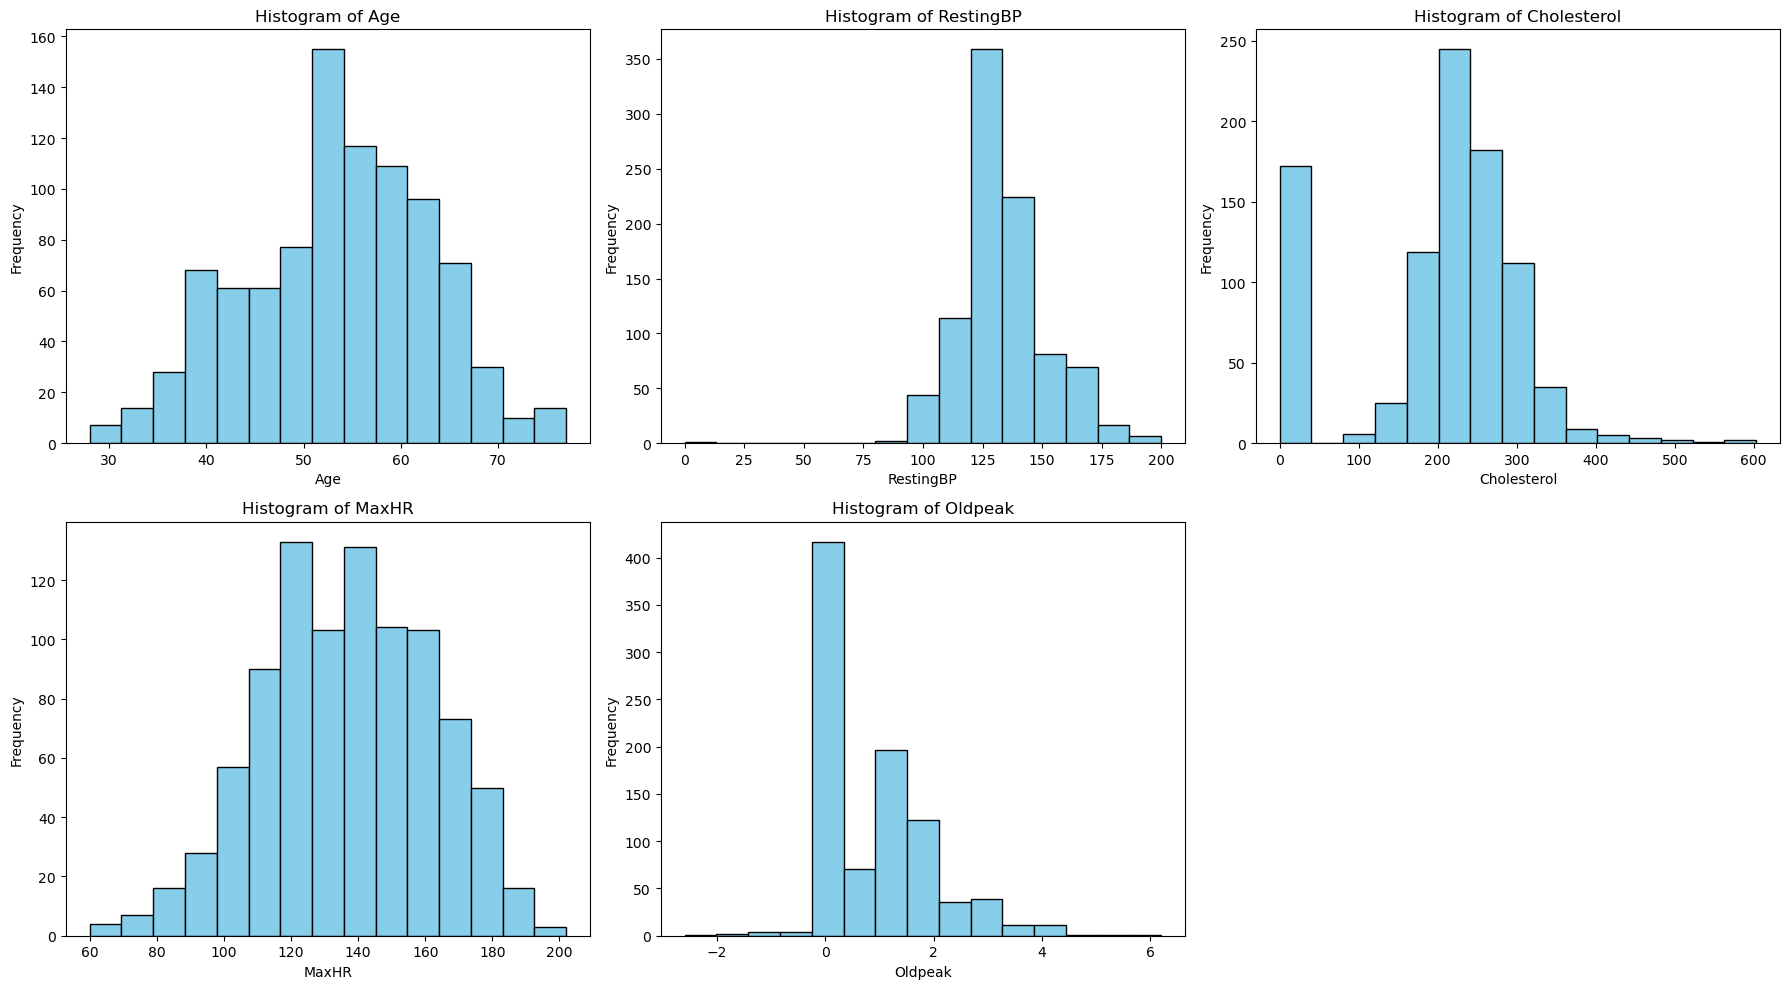

In [27]:
# Create histograms for all numerical columns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create histograms in a loop with subplots
for i, column in enumerate(numerical_columns):
    # Plot the histogram on the corresponding subplot
    axes[i].hist(heart[column], bins=15, color='skyblue', edgecolor='black')
    
    # Set labels and title for each subplot
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {column}')

# Leave the last subplot vacant
axes[-1].axis('off')  # This will hide the last subplot

# Adjust layout so plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

Let's also show this with a breakdown with and without "yes" for HeartDisease.

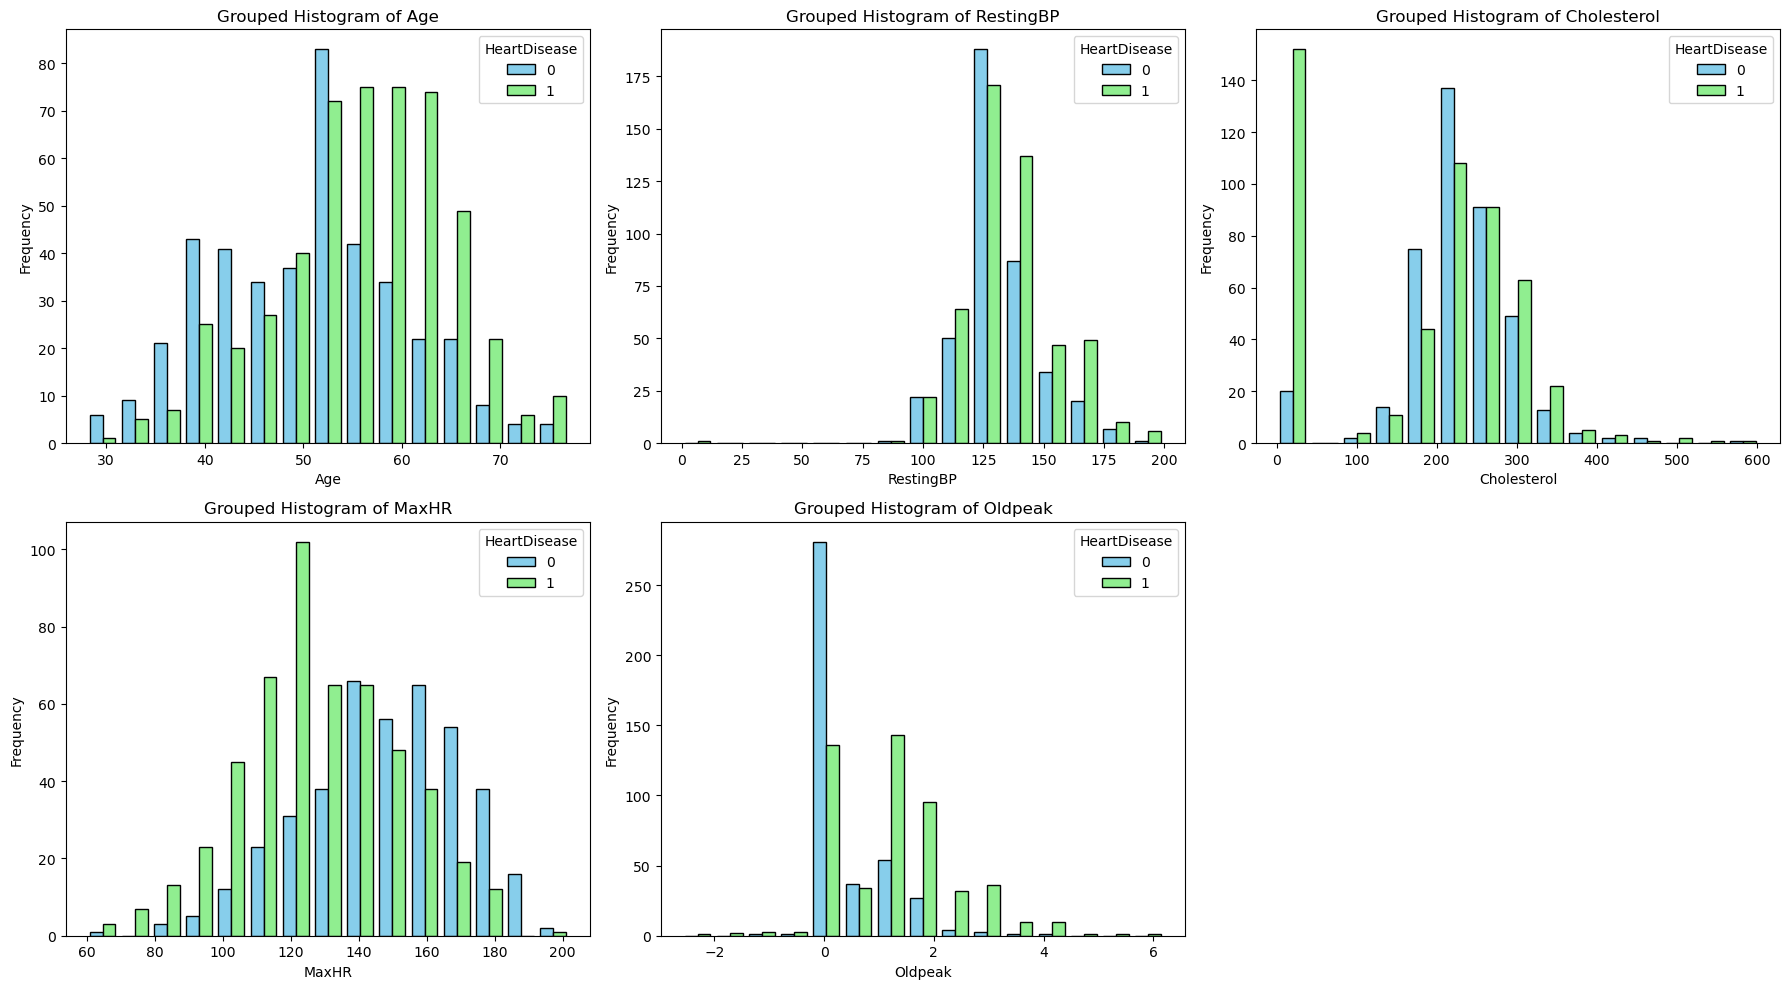

In [29]:
# Create histograms for all numerical columns (grouped for 'HeartDisease')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create histograms in a loop with subplots
for i, column in enumerate(numerical_columns):
    # Plot the histogram on the corresponding subplot
    axes[i].hist([heart[heart['HeartDisease'] == 0][column], heart[heart['HeartDisease'] == 1][column]], bins=15, color=['skyblue','lightgreen'], stacked = False, edgecolor='black')
    
    # Set labels and title for each subplot
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Grouped Histogram of {column}')
    axes[i].legend([0,1], title = 'HeartDisease')
    
# Leave the last subplot vacant
axes[-1].axis('off')  # This will hide the last subplot

# Adjust layout so plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

**Beware** when interpreting the above charts: in total there are some 25% more observations for which HeartDisease = 1 (green bars) than observations for which HeartDisease = 0 (blue bars). So generally the green bars are expected to be somewhat higher than the blue ones in case there is no correlation with the Target variable.

Keeping that in mind, it looks like HeartDisease is more common in case of:
* a higher Age
* a value of '0' for Cholesterol; but as said this is likely an invalid value (to address during Data cleaning)
* a lower value of MaxHR
* a higher value of Oldpeak

Another noteworthy observation is that for the negative values of Oldpeak, there are multiple different ones.

### Categorical features

There are six categorical features. Similar to what we did for the numerical features, let's create bar charts for each of them. And then also with a grouping for 'HeartDisease'

In [34]:
# Select the categorical columns

categorical_columns = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina','ST_Slope']

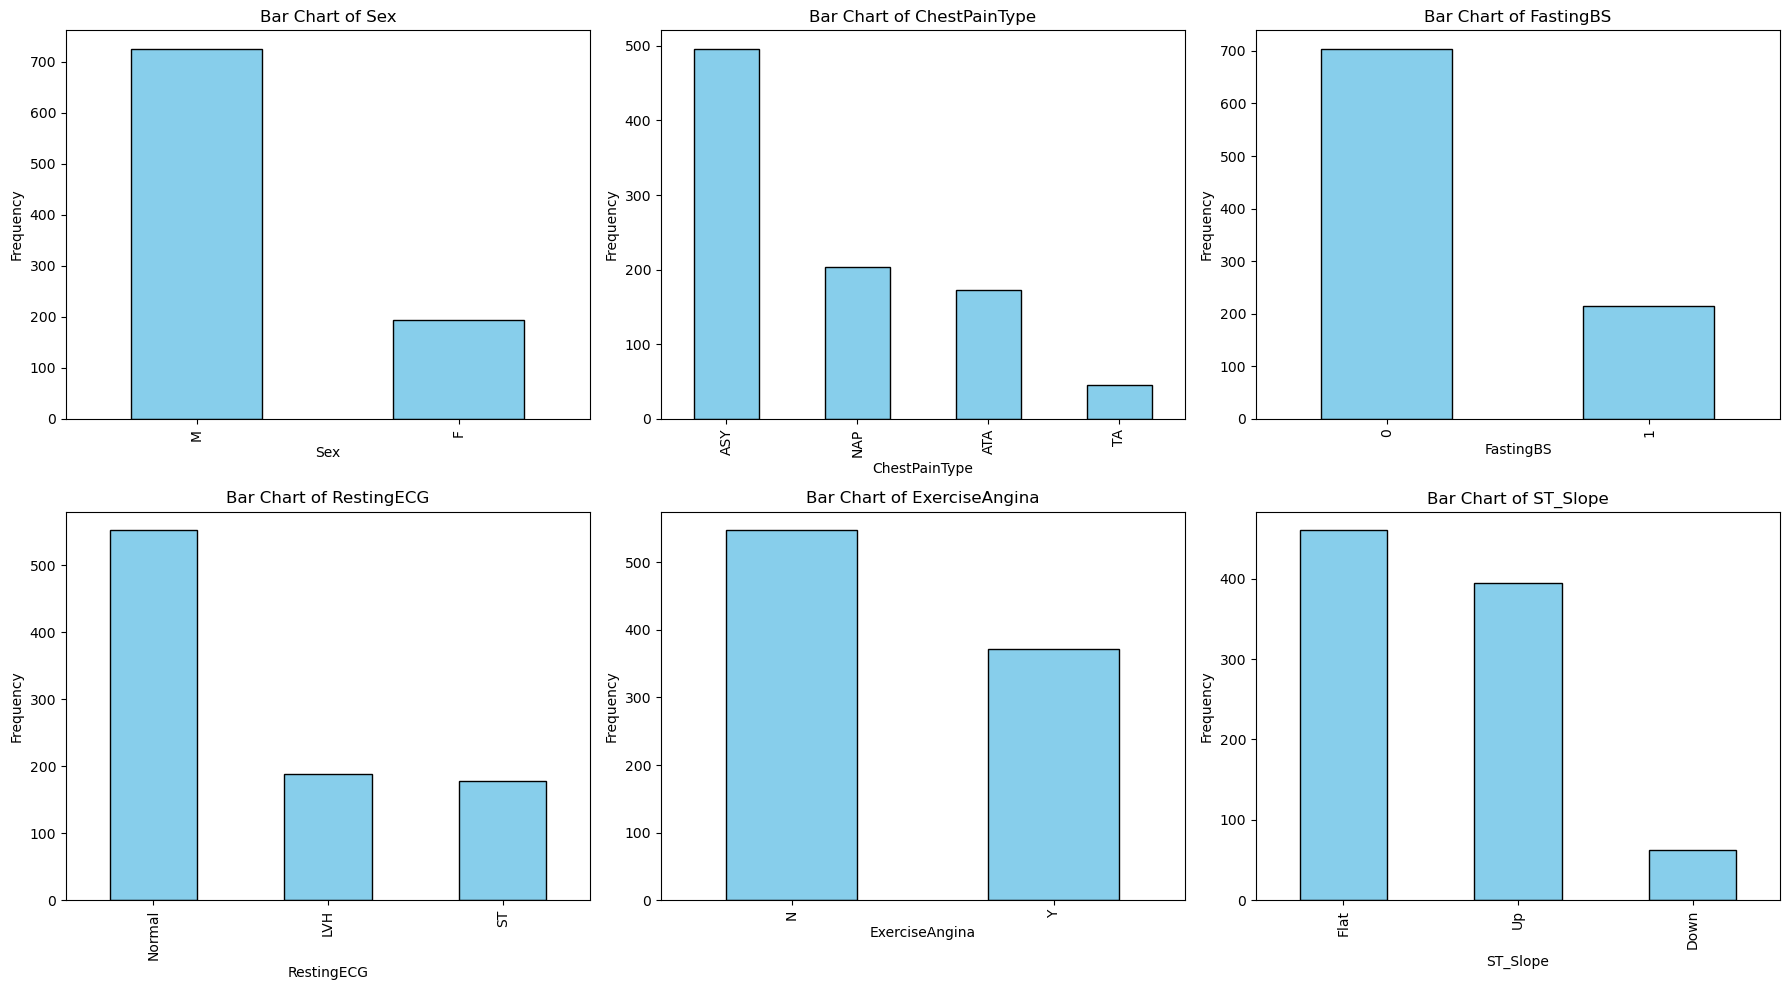

In [35]:
# Create bar charts for all categorical columns

# Create subplots (2x3 grid for 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Flatten the axes array for easy indexing in the loop
axes = axes.flatten()

# Create ungrouped bar charts in a loop with subplots
for i, column in enumerate(categorical_columns):
    # Count the occurrences of each category
    category_counts = heart[column].value_counts()
    
    # Plot the data on the corresponding subplot
    category_counts.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    
    # Set labels and title for each subplot
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Bar Chart of {column}')

# Adjust layout so plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

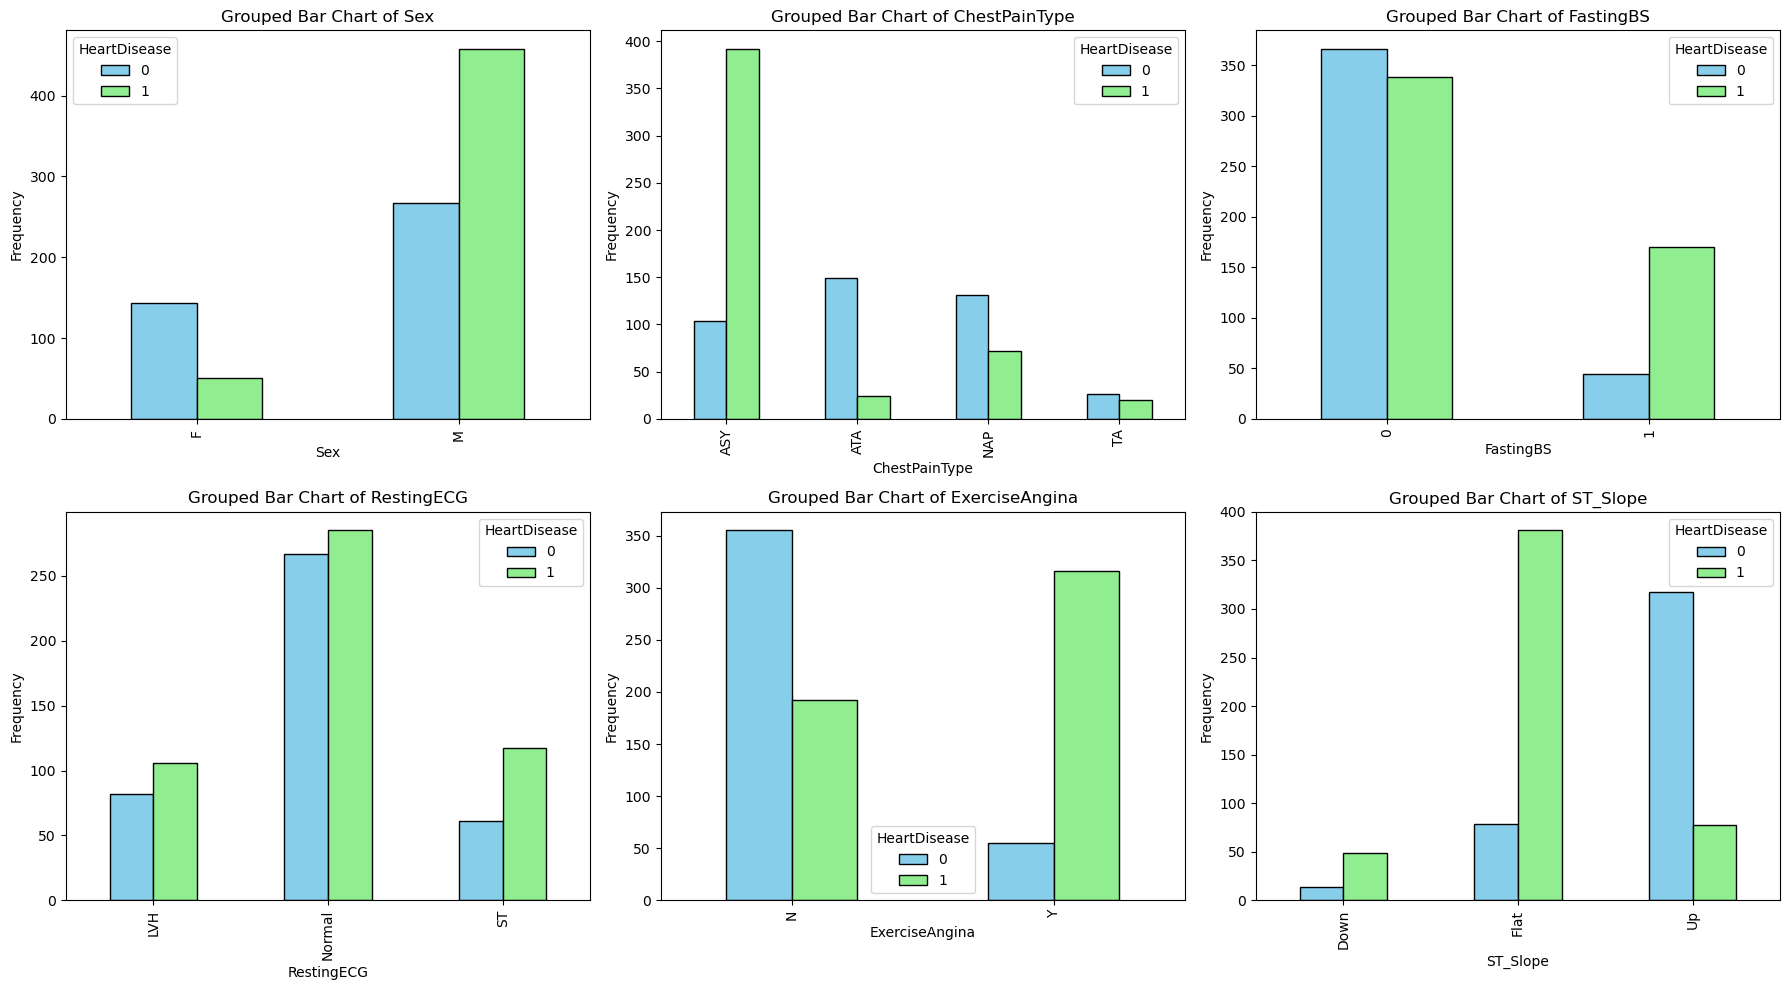

In [36]:
# Create bar charts for all categorical columns (grouped for 'HeartDisease')

# Create subplots (2x3 grid for 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Flatten the axes array for easy indexing in the loop
axes = axes.flatten()

# Create grouped bar charts in a loop with subplots
for i, column in enumerate(categorical_columns):
    # Group by the 'Group' column and count the occurrences for each group and category
    grouped_data = heart.groupby([column, 'HeartDisease']).size().unstack(fill_value=0)
    
    # Plot the grouped data on the corresponding subplot
    grouped_data.plot(kind='bar', stacked=False, ax=axes[i], color=['skyblue', 'lightgreen'], edgecolor='black')
    
    # Set labels and title for each subplot
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Grouped Bar Chart of {column}')

# Adjust layout so plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

As above, **beware** when interpreting the above charts: in total there are some 25% more observations for which HeartDisease = 1 (green bars) than observations for which HeartDisease = 0 (blue bars). So generally the green bars are expected to be somewhat higher than the blue ones in case there is no correlation with the Target variable.

Keeping that in mind, we can do the following observations:
* Sex. There are many more observations for Men then for Women. For Men, the chance of HeartDisease seems higher.
* ChestPaintType. 'ASY' is the most common value, being "Asymptomatic". *And* it is the ChestPainType for which HeartDisease = yes is much more common.
* FastingBS = 1 is not so common. But if it is, then HeartDisease = yes is quite common.
* ExcerciseAngina seems to be quite correlated. For 'N', HeartDisease = yes is not so common, for 'Y', HeartDisease = yes is very common.
* ST_Slope seems to be quite correlated. For 'Flat', HeartDisease = yes is common, for 'Up' HeartDisease = yes is uncommon

## Data cleaning

During data exploration and analysis we observed there are no missing (null) values, but several unlikely values to be subject to cleaning:
* for Cholesterol there are 172 zero values
* for RestingBP there is 1 zero value
* for Oldpeak there are 13 negative values.

Let's address that.

For **Cholesterol**, this is about almost 20% of the observations. So we should not simply delete these observations. But rather impute another value. And be careful with what we insert, rather than simply taking the mean or median of the entire column straightaway.

Before deciding what to to do, let's first calculate some statistics of the rows where Cholesterol is *not* zero.

In [41]:
# Show statistics for the observations where Cholesterol is valid (non-zero)
heart[heart['Cholesterol'] != 0]['Cholesterol'].describe()

count    746.000000
mean     244.635389
std       59.153524
min       85.000000
25%      207.250000
50%      237.000000
75%      275.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [42]:
# Get statistics from this limited set of observations:
print('Statistics for observations where Cholesterol has a valid (non-zero) value')
print('\n')
print('Number of observations (total):', heart[heart['Cholesterol'] != 0]['Cholesterol'].count())
print('Mean value of Cholesterol for those:', heart[heart['Cholesterol'] != 0]['Cholesterol'].mean())
print('Median value of Cholesterol for those:', heart[heart['Cholesterol'] != 0]['Cholesterol'].median())
print('\n')
print('Number of observations where HeartDisease = 1:', heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==1)]['Cholesterol'].count())
print('Mean value of Cholesterol for those:', heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==1)]['Cholesterol'].mean())
print('Median value of Cholesterol for those:', heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==1)]['Cholesterol'].median())
print('\n')
print('Number of observations where HeartDisease = 0:', heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==0)]['Cholesterol'].count())
print('Mean value of Cholesterol for those:', heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==0)]['Cholesterol'].mean())
print('Median value of Cholesterol for those:', heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==0)]['Cholesterol'].median())

Statistics for observations where Cholesterol has a valid (non-zero) value


Number of observations (total): 746
Mean value of Cholesterol for those: 244.6353887399464
Median value of Cholesterol for those: 237.0


Number of observations where HeartDisease = 1: 356
Mean value of Cholesterol for those: 251.06179775280899
Median value of Cholesterol for those: 246.0


Number of observations where HeartDisease = 0: 390
Mean value of Cholesterol for those: 238.76923076923077
Median value of Cholesterol for those: 231.5


The above statistics imply that it seems sensible to impute different values for HeartDisease being 0 or 1, given the difference for mean and median values for both categories. Whether than to use the mean or the median, since the distribution is a bit skewed (see histograms above) we might take the median. Looking at the numbers, the differences are not that high, it doesn't matter so much probably, so let's use the (for imputing values commonly used) mean after all.

In [44]:
# Impute new values for Cholestorols, for the rows where Cholesterol = 0

impute_for_chol0_heart1 = heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==1)]['Cholesterol'].mean().astype("int64")
heart.loc[(heart['Cholesterol'] == 0) & (heart['HeartDisease']==1),'Cholesterol'] = impute_for_chol0_heart1

impute_for_chol0_heart0 = heart[(heart['Cholesterol'] != 0) & (heart['HeartDisease']==0)]['Cholesterol'].mean().astype("int64")
heart.loc[(heart['Cholesterol'] == 0) & (heart['HeartDisease']==0),'Cholesterol'] = impute_for_chol0_heart0

# Show new statistics to check the result
heart['Cholesterol'].describe()

count    918.000000
mean     245.544662
std       53.382201
min       85.000000
25%      214.000000
50%      250.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

That looks okay.

For **RestingBP** (only one zero-value) let's just insert the mean of the column.

In [46]:
# Calculate and impute new values for the row() where RestingBP = 0

impute_for_restingbp0 = heart['RestingBP'].mean().astype('int64')
heart.loc[heart['RestingBP'] == 0 ,'RestingBP'] = impute_for_restingbp0

# Show new statistics to check the result
heart['RestingBP'].describe()

count    918.000000
mean     132.540305
std       17.989941
min       80.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64

That looks okay.

For **Oldpeak**, I found it a bit hard to figure out whether negative values (of which we had 13) are allowed or not.

I decided to leave the values as they are, because:
* There are multiple different negative values in the observations, making it more likely to be accurate. If there was only one, it would be some sort of 'unknown' or 'default entry' value.
* There are only 13 negative values, being part of a continous range of values, so the impact is not going to be so large anyway for machine learning
* According to ChatGPT, a negative value is actually possible...

## Machine learning, preparations

Having clean data, let's do next steps to prepare for machine learning.

### Create dummy variables

A first step to do before feature selection, is replacing all categorical features with dummy variables. We'll use one-hot encoding.

In [51]:
# Replace categorical features by dummies (one-hot encoding)
heart = pd.get_dummies(data = heart, columns = categorical_columns, drop_first = False, dtype = int)

# Show info to check the result
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   MaxHR              918 non-null    int64  
 4   Oldpeak            918 non-null    float64
 5   HeartDisease       918 non-null    int64  
 6   Sex_F              918 non-null    int32  
 7   Sex_M              918 non-null    int32  
 8   ChestPainType_ASY  918 non-null    int32  
 9   ChestPainType_ATA  918 non-null    int32  
 10  ChestPainType_NAP  918 non-null    int32  
 11  ChestPainType_TA   918 non-null    int32  
 12  FastingBS_0        918 non-null    int32  
 13  FastingBS_1        918 non-null    int32  
 14  RestingECG_LVH     918 non-null    int32  
 15  RestingECG_Normal  918 non-null    int32  
 16  RestingECG_ST      918 non

In [52]:
# Also show a sample to check the result of the one-hot encoding

heart.head(5)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
1,49,160,180,156,1.0,1,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,98,0.0,0,0,1,0,1,...,1,0,0,0,1,1,0,0,0,1
3,48,138,214,108,1.5,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
4,54,150,195,122,0.0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1


That looks good.

### Feature selection

While the earlier charts (in section Data analysis) provided interesting insights already, let's now get more insight in the correlation between the features, and in particular the correlation with target column HeartDisease.

We'll create heatmaps.

In [55]:
# Get correlations between all columns
heart_corr = heart.corr()

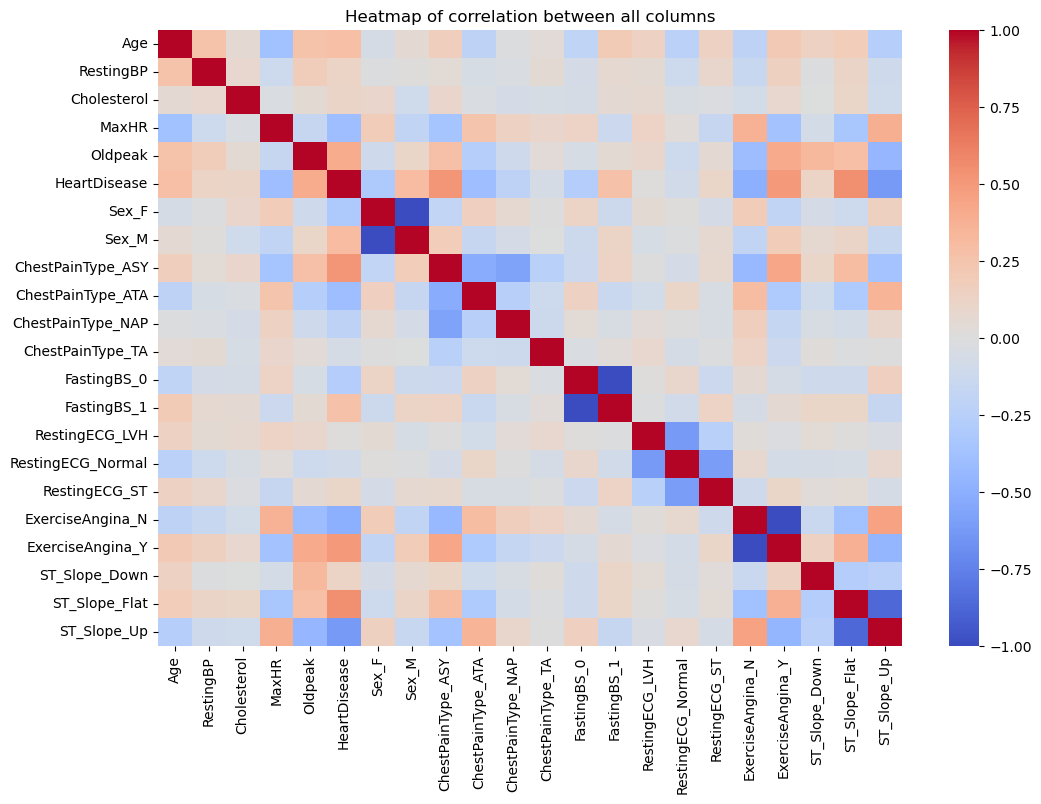

In [56]:
# Create a heatmap of these correlations
plt.figure(figsize=(12,8))  # Set the figure size
sns.heatmap(heart_corr, annot=False, cmap='coolwarm')  # 'annot=True' adds values to each cell
plt.title("Heatmap of correlation between all columns")
plt.show()

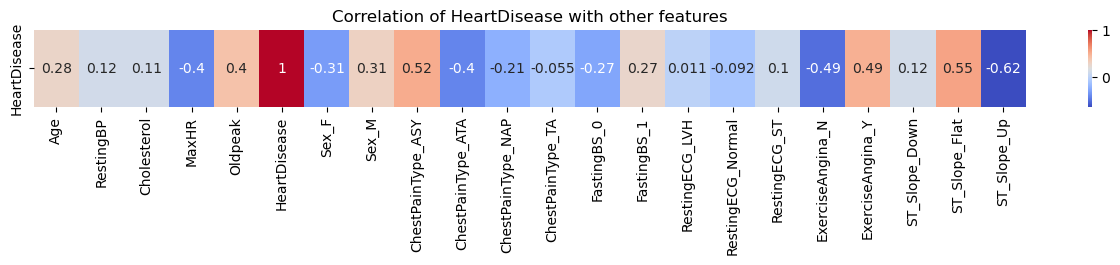

In [57]:
# Show the correlation of all features with HeartDisease

corr_with_column = heart_corr['HeartDisease']

#Convert it to a DataFrame (for easier plotting)
corr_df = pd.DataFrame(corr_with_column)

# Create a heatmap using Seaborn
plt.figure(figsize=(16,1))
sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=True)  # Transpose to display horizontally
plt.title(f"Correlation of HeartDisease with other features")
plt.show()

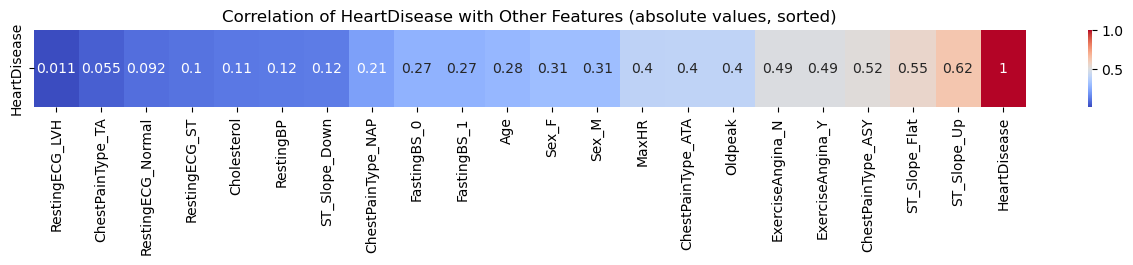

In [58]:
# Show the correlation of all features with HeartDisease (absolute values, sorted)

corr_with_column = heart_corr['HeartDisease'].abs().sort_values()

#Convert it to a DataFrame (for easier plotting)
corr_df = pd.DataFrame(corr_with_column)

# Create a heatmap using Seaborn
plt.figure(figsize=(16,1))
sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=True)  # Transpose to display horizontally
plt.title(f"Correlation of HeartDisease with Other Features (absolute values, sorted)")
plt.show()

Now let us do an initial selection of features to use for machine learning. We obviously want to include those features having a high correlation according to the heat map just above. And also those for which based on the earlier graphs (section Data analysis) we observed they appear to relate to the presence of heart disease.

It remains a bit arbitrary but taking those with a correlation of 0.27 and above seems good then. With the following comments:
* FastingBS_0 and FastingBS_1 are mutually exclusive, so we include only one of them
* Same applies to Sex_F and Sex_M 
* Same applies to ExcerciseAngina_N and ExcerciseAngina_Y
* It feels a bit odd to include ChestPaintType_ASY as this means 'asymptomatic' (no symptoms), but let's do this anyway

In [60]:
# Create list including selected features

selected_features = corr_with_column[corr_with_column > 0.26].index.tolist()
to_remove = ('FastingBS_0','Sex_F', 'ExerciseAngina_N', 'HeartDisease')
selected_features = [x for x in selected_features if x not in to_remove]

# Print to checkk the result
print(selected_features)

['FastingBS_1', 'Age', 'Sex_M', 'MaxHR', 'ChestPainType_ATA', 'Oldpeak', 'ExerciseAngina_Y', 'ChestPainType_ASY', 'ST_Slope_Flat', 'ST_Slope_Up']


Let's also create a variable containing the target variable.

In [62]:
# Create variable target

target = "HeartDisease"

## Machine Learning (KNN)

We'll use KNN (K nearest neighbors) for this classification problem. 

### Individual features

To start with, let's do a classification using KNN with each of the selected features individually.  
Training will be done with 80% of the data, testing on the remaining 20%.  
Different values of k (number of nearest neighbors) will be tried.

We'll evaluate model performance by measuring the accuracy (percentage correct predictions) on the test set.

In [65]:
# Split the data in a training and a test set

X = heart.drop([target], axis=1)
y = heart[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 417)

In [66]:
# Iterate through the selected features, and for each of them train a KNN-model and get the accuracy using the test set

for a_feature in selected_features:
    for k in [1, 3, 10]:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[a_feature].values.reshape(-1,1), y_train)
        accuracy = knn.score(X_test[a_feature].values.reshape(-1,1), y_test)
        print ('KNN with feature', a_feature, 'and k =', k, 'the accuracy is', accuracy)

KNN with feature FastingBS_1 and k = 1 the accuracy is 0.46195652173913043
KNN with feature FastingBS_1 and k = 3 the accuracy is 0.5380434782608695
KNN with feature FastingBS_1 and k = 10 the accuracy is 0.5652173913043478
KNN with feature Age and k = 1 the accuracy is 0.5
KNN with feature Age and k = 3 the accuracy is 0.5
KNN with feature Age and k = 10 the accuracy is 0.5543478260869565
KNN with feature Sex_M and k = 1 the accuracy is 0.5380434782608695
KNN with feature Sex_M and k = 3 the accuracy is 0.6358695652173914
KNN with feature Sex_M and k = 10 the accuracy is 0.46195652173913043
KNN with feature MaxHR and k = 1 the accuracy is 0.6032608695652174
KNN with feature MaxHR and k = 3 the accuracy is 0.5760869565217391
KNN with feature MaxHR and k = 10 the accuracy is 0.6358695652173914
KNN with feature ChestPainType_ATA and k = 1 the accuracy is 0.6630434782608695
KNN with feature ChestPainType_ATA and k = 3 the accuracy is 0.6630434782608695
KNN with feature ChestPainType_ATA a

Observations:
* The features that had the highest correlation with HeartDisease are indeed the best predictors
* The value of k does not seem to matter a lot; k=3 seems fine for all predictors
* Best prediction is with ST_Slope_Up, with an accuracy of 0.82

### Features combined

Let's now train a KNN classifier using multiple features at the same time.  
Before doing that, we first need to scale all (selected) features so they are in the range (0,1), to avoid some features having much more influence than others.

In [69]:
# Scale all selected features (training data)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train[selected_features])

# Convert the scaled data back into a dataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_features)

# Print a sample to check the result
X_train_scaled_df.head(5)

,FastingBS_1,Age,Sex_M,MaxHR,ChestPainType_ATA,Oldpeak,ExerciseAngina_Y,ChestPainType_ASY,ST_Slope_Flat,ST_Slope_Up
0,1.0,0.551020,1.0,0.464789,0.0,0.420455,1.0,1.0,1.0,0.0
1,1.0,0.510204,1.0,0.563380,0.0,0.465909,1.0,1.0,1.0,0.0
2,0.0,0.591837,1.0,0.197183,0.0,0.431818,1.0,1.0,1.0,0.0
3,0.0,0.693878,0.0,0.725352,0.0,0.295455,0.0,1.0,0.0,1.0
4,1.0,0.530612,1.0,0.457746,0.0,0.409091,1.0,1.0,1.0,0.0


That looks okay. Let's use the same scaler to scale the test data.

In [71]:
# Scale all selected features (test data)

X_test_scaled = scaler.transform(X_test[selected_features])

# Convert the scaled data back into a Pandas DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=selected_features)

# Show statistics to check the result
X_test_scaled_df.describe()

,FastingBS_1,Age,Sex_M,MaxHR,ChestPainType_ATA,Oldpeak,ExerciseAngina_Y,ChestPainType_ASY,ST_Slope_Flat,ST_Slope_Up
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,0.233696,0.504991,0.739130,0.570537,0.168478,0.388031,0.391304,0.554348,0.478261,0.478261
std,0.424335,0.199782,0.440307,0.180026,0.375312,0.112942,0.489374,0.498394,0.500890,0.500890
min,0.000000,0.020408,0.000000,0.084507,0.000000,0.204545,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.367347,0.000000,0.436620,0.000000,0.295455,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.510204,1.000000,0.588028,0.000000,0.352273,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.658163,1.000000,0.704225,0.000000,0.457386,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,0.929577,1.000000,0.772727,1.000000,1.000000,1.000000,1.000000


That looks good.

Let's now do two experiments:
* with all of the features used above
* with the 3 best performing features of the experiments above

For both of them with multiple different values of k, and evaluating with the accuracy of predictions on the test set.

In [73]:
# Run K train a KNN-model and get the accuracy using the test set
# Use all earlier selected features

print ('Features used:', X_train_scaled_df.columns.tolist())

for k in [1, 3, 10, 25, 100]:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train_scaled_df, y_train)
        accuracy = knn.score(X_test_scaled_df, y_test)
        print ('KNN with k =', k, 'the accuracy is', accuracy)

Features used: ['FastingBS_1', 'Age', 'Sex_M', 'MaxHR', 'ChestPainType_ATA', 'Oldpeak', 'ExerciseAngina_Y', 'ChestPainType_ASY', 'ST_Slope_Flat', 'ST_Slope_Up']
KNN with k = 1 the accuracy is 0.8260869565217391
KNN with k = 3 the accuracy is 0.8206521739130435
KNN with k = 10 the accuracy is 0.8586956521739131
KNN with k = 25 the accuracy is 0.9130434782608695
KNN with k = 100 the accuracy is 0.8913043478260869


In [74]:
# Run K train a KNN-model and get the accuracy using the test set
# Use top 3 earliers selected features earlier selected features

# Take the 3 with the best performance earlier
selected_features_subset = ['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY']

print ('Features used:', selected_features_subset)

for k in [1, 3, 10, 25, 100]:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train_scaled_df[selected_features_subset], y_train)
        accuracy = knn.score(X_test_scaled_df[selected_features_subset], y_test)
        print ('KNN with k =', k, 'the accuracy is', accuracy)

Features used: ['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY']
KNN with k = 1 the accuracy is 0.8315217391304348
KNN with k = 3 the accuracy is 0.8315217391304348
KNN with k = 10 the accuracy is 0.8315217391304348
KNN with k = 25 the accuracy is 0.8206521739130435
KNN with k = 100 the accuracy is 0.8206521739130435


What we observe is that using all selected features is giving the better result. And that the accuracy is quite a bit higher now. For the experiment with all selected features and k=25, an accuracy of 0.913 was reached!

### Grid search

We already saw that the value of k matters, in a sense that the accuracy differs depending on its value.  
Aiming to further optimize the model, let's do a grid search for k, and also for two other hyperparameters.

Using GridSearchCV, what we will get is the best values for these hyperparameters (based on cross-validation within the training dataset), and the trained model ('estimator') with those parameters.

In [77]:
# Initialize the KNN estimator
knn = KNeighborsClassifier()

# Define the parameter grid (values to try for n_neighbors and other hyperparameters)
param_grid = {
    'n_neighbors': np.arange(10, 50),  # Try different values of k
    'weights': ['uniform', 'distance'],  # Try uniform and distance-based weights
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Try different distance metrics
}

# Initialize GridSearchCV with the KNN estimator and the parameter grid
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring = 'accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train_scaled_df[selected_features], y_train)

# Get the best parameters and the best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Print the best score
print("Best accuracy (cross-validated score on training set when using best parameters)", grid_search.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
Best accuracy (cross-validated score on training set when using best parameters) 0.8623800205013511


Having the best estimator at hand based on the grid search, let's use it to make predictions for the test set.

In [79]:
# Use the best model to make predictions on the test set
y_pred = best_estimator.predict(X_test_scaled_df[selected_features])

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy with best parameters:", accuracy)

Test set accuracy with best parameters: 0.9021739130434783


What we see is that:
* the accuracy using the training set is 86.2%
* the accuracy on the test set is 90.2%

Remarkable to see a higher accuracy on the test set. I have no real other explanation than that it is 'luck' with how the data was split into training and test set, and then how the 5 folds were made within the training set.

Since at the same time our numbers are quite small altogether, and for some feature values the numbers very small. E.g. if only a small number of observations Sex = F in the first place, and then again use only a part of this for training (80% in training set, and 80% of that in each cross-fold validation training iteration) there is really not that much data left to train on, making the model less accurate, and prone to high variance depending on the data that you put in to test.

Another observation is that the accuracy on the test set (90.2%) is actually lower than the 91.3% we had found earlier (for k = 25 and metric = 'minkowski' being the default). A similar explanation will apply there: apparently that model did worse on the training set so GridsearchCV did not select it, but did well on the test set. By chance, due to the small size of the data such thing can happen.

### Confusion matrix

So far we evaluated the model simply by looking at the accuracy: the percentage of correct prediction.

What is also interesting to get insight in, is whether it is more accurate for getting the prediction wrong for either the case where in reality HeartDisease = 1 (which would be a 'false negative') or for the case where in reality HeartDisease = 0 (which would be a 'false positive').

That insight would be very helpful when interpreting any outcome for a new data point. Let's create a confusion matrix to gain this insight.

Confusion Matrix:
 [[76  9]
 [ 9 90]]


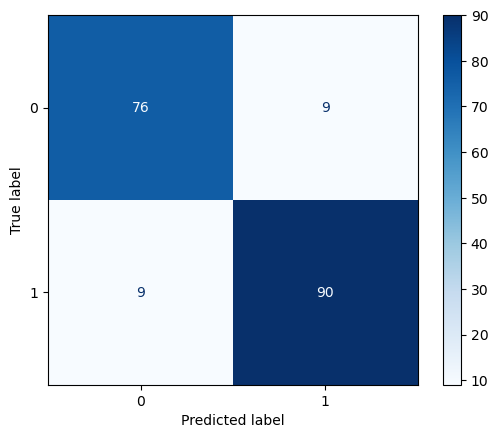

In [82]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix using a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0','1'])
disp.plot(cmap=plt.cm.Blues)

# Display the plot
plt.show()

What we can see is that:
* the test set approximately contained similar amounts of patients with and without heart disease
* for both categories, 9 predictions were wrong (9 false positives and 9 false negatives).

So the model appears to perform (predict) similarly accurate both for the case where a patient actually has a heart disease or not.

## Conclusions and next steps

Main observations:
* If wondering which feature is by itself the best predictor of heart disease, it would be ST_Slope 
* Best accuracy is reached when using a fairly large selection of features though (both numerical and categorical)
* For which an accuracy of approximately 90% was reached, without being a better predictor for either 'positive' or 'negative' cases
* The measured accuracy is quite dependent on what happened to be the data selected for training and evaluationg due to the small data size

Possible next steps:
* More extensive experiments with combination of features
* Try out another classifier altogether, e.g. random forest
* Get more data to improve accuracy